# Train Detectron2 NN from V2 COCO dataset

Using the **OpenCV auto-annotated** V2 dataset (clean filters and saturated filters together), train a detectron2 neural network. 



### Register the dataset using Detectron2 tutorial

Use tile dataset only (right resolution for .pth used with Labelbox) 

https://github.com/facebookresearch/detectron2/blob/main/docs/tutorials/datasets.md



In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
DatasetCatalog.clear()

In [2]:


register_coco_instances("particles", {}, 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V2/5_coco_annotations/particles/train/instances_particles_train2023.json", 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V2/5_coco_annotations/particles/train/particles_train2023/")

In [3]:
!ls ../../../0_DATA/IMPTOX/01-01_image_library/V2/5_coco_annotations

particles  train


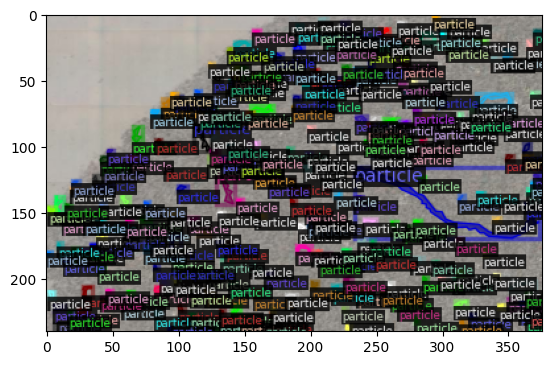

In [4]:
import random

import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("particles")
particles_metadata = MetadataCatalog.get("particles")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=particles_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.OUTPUT_DIR = "./TrainDetectron2Model"
cfg.merge_from_file(
    #"../../Other/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    "../../Other/detectron2/configs/Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
) # Detectron2 accidentally installed at more than one place
cfg.DATASETS.TRAIN = ("particles",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.DEVICE = 'cuda:1'  # cpu or cuda
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.008
cfg.SOLVER.MAX_ITER = (
    500
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    512
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class: particle

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#

[09/21 10:15:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_head.0.fc1.{bias, weight}
roi_heads.box_head.0.fc2.{bias, weight}
roi_heads.box_head.1.fc1.{bias, weight}
roi_heads.box_head.1.fc2.{bias, weight}
roi_heads.box_head.2.fc1.{bias, weight}
roi_heads.box_head.2.fc2.{bias, weight}
roi_heads.box_predictor.0.bbox_pred.{bias, weight}
roi_heads.box_predictor.0.cls_score.{bias, weight}
roi_heads.box_predictor.1.bbox_pred.{bias, weight}
roi_heads.box_predictor.1.cls_score.{bias, weight}
roi_heads.box_predictor.2.bbox_pred.{bias, weight}
roi_heads.box_pre

[09/21 10:15:28 d2.engine.train_loop]: Starting training from iteration 0


/home/thibault.schowing/data-local/miniconda3/envs/aienv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/21 10:15:37 d2.utils.events]:  eta: 0:02:15  iter: 19  total_loss: 4.335  loss_cls_stage0: 0.5949  loss_box_reg_stage0: 0.1909  loss_cls_stage1: 0.5617  loss_box_reg_stage1: 0.1895  loss_cls_stage2: 0.5781  loss_box_reg_stage2: 0.1433  loss_mask: 0.6916  loss_rpn_cls: 0.8115  loss_rpn_loc: 0.458    time: 0.2909  last_time: 0.2931  data_time: 0.0540  last_data_time: 0.0006   lr: 0.0003117  max_mem: 0M


2023-09-21 10:15:37.761045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 10:15:38.627949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[09/21 10:15:46 d2.utils.events]:  eta: 0:02:12  iter: 39  total_loss: 3.6  loss_cls_stage0: 0.4974  loss_box_reg_stage0: 0.2677  loss_cls_stage1: 0.4619  loss_box_reg_stage1: 0.224  loss_cls_stage2: 0.4409  loss_box_reg_stage2: 0.1875  loss_mask: 0.6385  loss_rpn_cls: 0.4457  loss_rpn_loc: 0.3957    time: 0.3141  last_time: 0.2364  data_time: 0.0060  last_data_time: 0.0009   lr: 0.00063138  max_mem: 0M
[09/21 10:15:52 d2.utils.events]:  eta: 0:02:06  iter: 59  total_loss: 3.415  loss_cls_stage0: 0.4065  loss_box_reg_stage0: 0.4027  loss_cls_stage1: 0.3869  loss_box_reg_stage1: 0.3735  loss_cls_stage2: 0.3455  loss_box_reg_stage2: 0.2132  loss_mask: 0.496  loss_rpn_cls: 0.369  loss_rpn_loc: 0.4343    time: 0.3057  last_time: 0.3977  data_time: 0.0051  last_data_time: 0.0073   lr: 0.00095106  max_mem: 0M
[09/21 10:15:58 d2.utils.events]:  eta: 0:02:00  iter: 79  total_loss: 3.289  loss_cls_stage0: 0.3926  loss_box_reg_stage0: 0.391  loss_cls_stage1: 0.3742  loss_box_reg_stage1: 0.3823  

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = ("particles", )
cfg.TEST.DETECTIONS_PER_IMAGE = 2000
predictor = DefaultPredictor(cfg)

[07/13 14:20:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./TrainDetectron2Model/model_final.pth ...


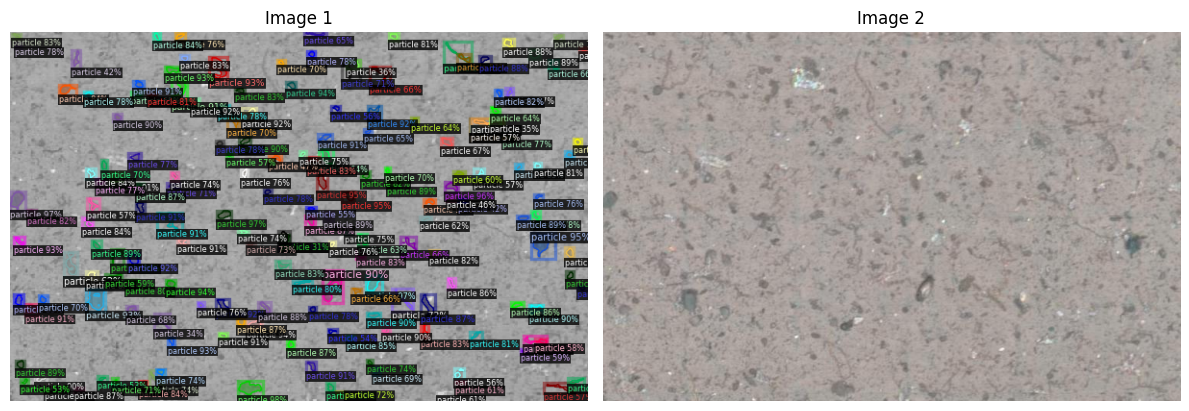

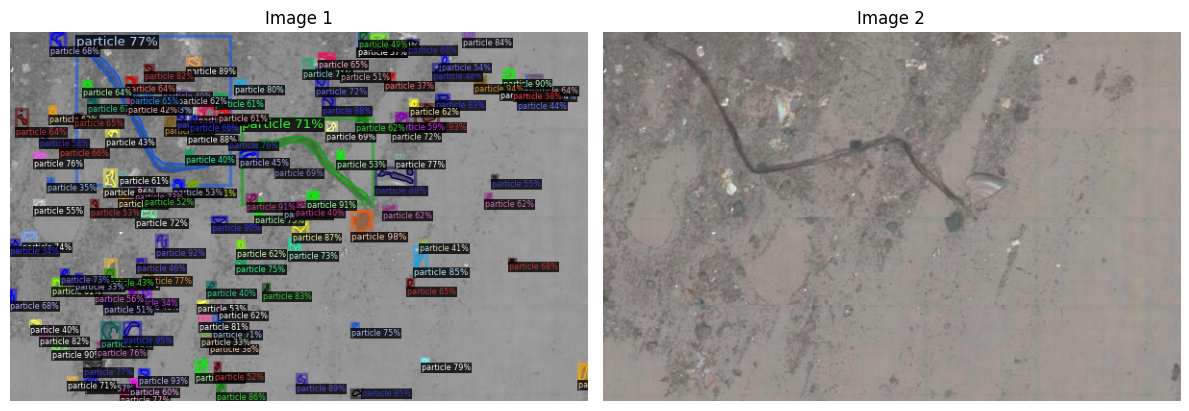

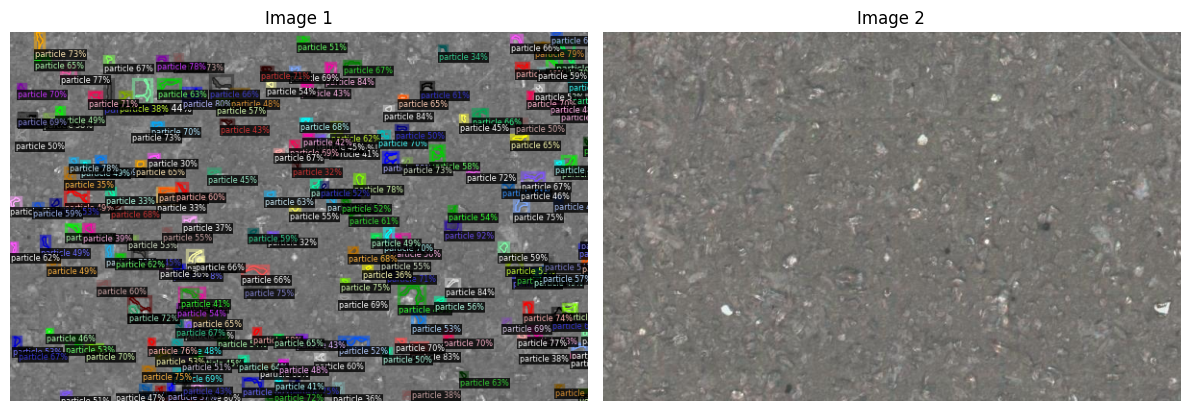

In [17]:
from detectron2.utils.visualizer import ColorMode
import PIL

for d in random.sample(dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    
    # Test augment brightness and contrast
    # https://stackoverflow.com/questions/50474302/how-do-i-adjust-brightness-contrast-and-vibrance-with-opencv-python
    #brightness = -10
    #contrast = 127
    #img = np.int16(img)
    #img = img * (contrast/127+1) - contrast + brightness
    #img = np.clip(img, 0, 255)
    #img = np.uint8(img)
    
    # ------
    #image = PIL.Image.open(d["file_name"])

    #img = np.array(PIL.ImageEnhance.Contrast(image).enhance(1.2))
    
    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=particles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns for the images
    axes[0].imshow(v.get_image()[:, :, ::-1])  # Display the first image in the left subplot
    axes[0].set_title("Image 1")  # Set a title for the first image
    axes[0].axis('off')  # Turn off the axis for the first image

    axes[1].imshow(img)  # Display the second image in the right subplot
    axes[1].set_title("Image 2")  # Set a title for the second image
    axes[1].axis('off')  # Turn off the axis for the second image

    plt.tight_layout()  # Adjust the layout for better spacing
    plt.show()




    
    #plt.figure(figsize=(10, 8))
    #plt.imshow(v.get_image()[:, :, ::-1])
    #plt.show()
   